In [ ]:
from IPython import get_ipython
from IPython.display import display
# %%
# 1. Instalar dependencias si es necesario
!pip install -q nltk
# Instalar la versión más reciente de scikit-learn
!pip install -U scikit-learn
!pip install wordcloud
!pip install seaborn # Add seaborn
# %%

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.



Tema #0:
['systems', 'computer', 'introduction', 'compsci', 'advanced', 'internet', 'graphics', 'things', 'intelligent', 'engineering']
------------------------------

Tema #1:
['architecture', 'business', 'computing', 'quantum', 'software', 'autonomous', 'speech', 'performance', 'systems', 'digital']
------------------------------

Tema #2:
['programming', 'data', 'engineering', 'cloud', 'reinforcement', 'learning', 'mining', 'solutions', 'development', 'application']
------------------------------

Tema #3:
['software', 'analysis', 'data', 'intelligence', 'artificial', 'engineering', 'systems', 'algorithms', 'processing', 'language']
------------------------------

Tema #4:
['learning', 'machine', 'thesis', 'deep', 'architectures', 'development', 'applications', 'analysis', 'embedded', 'processing']
------------------------------

Tema #5:
['computing', 'technology', 'theory', 'data', 'knowledge', 'tesis', 'applications', 'information', 'networks', 'big']
---------------------------

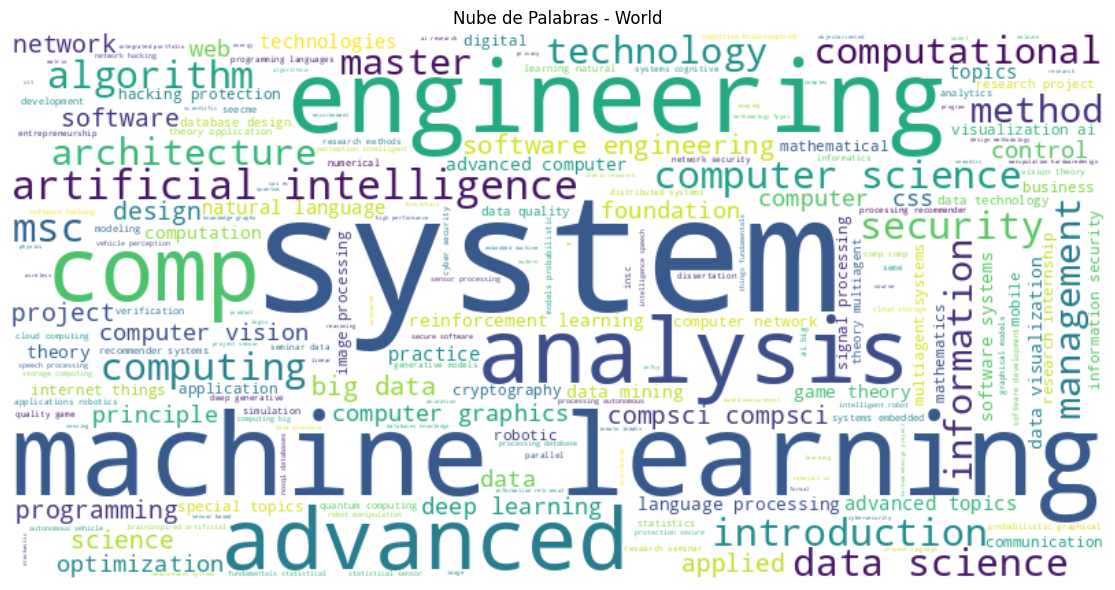

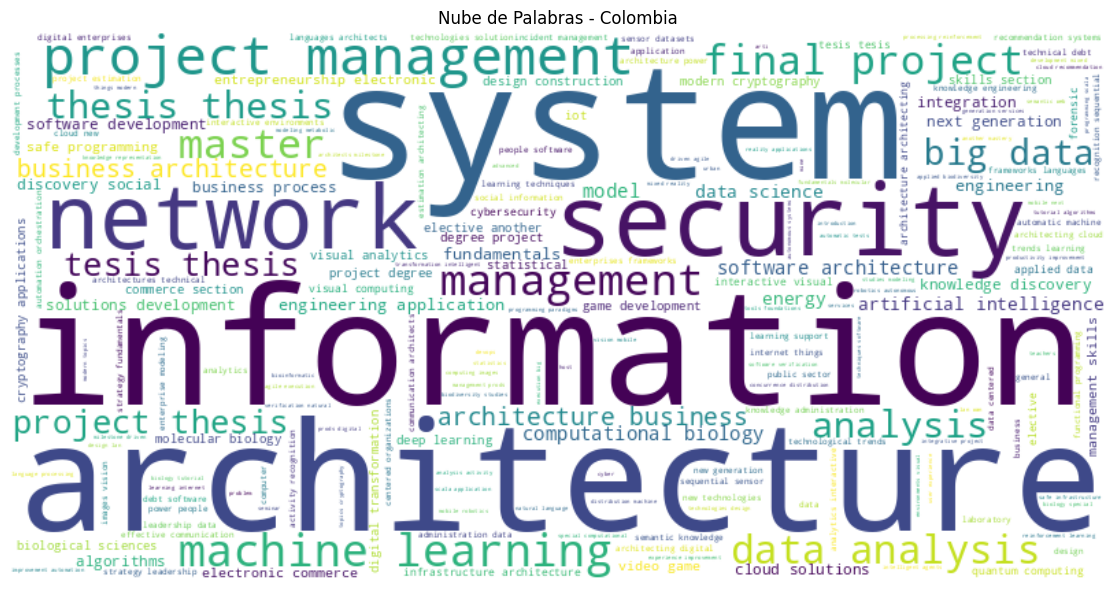


==== Frecuencia de Palabras en World ====


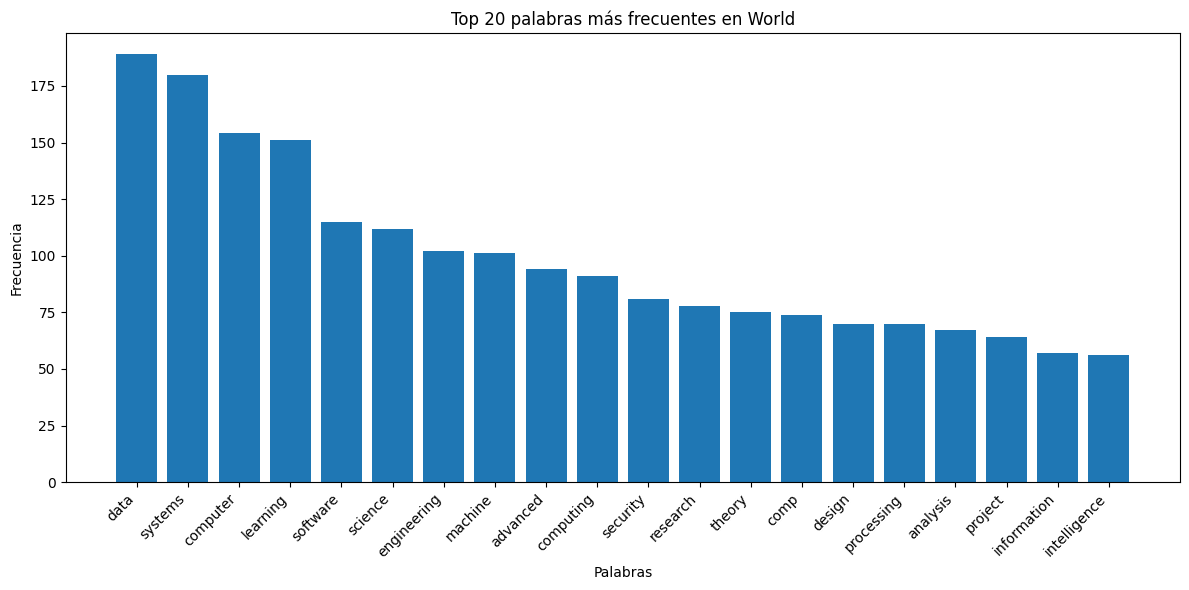


==== Frecuencia de Palabras en Colombia ====


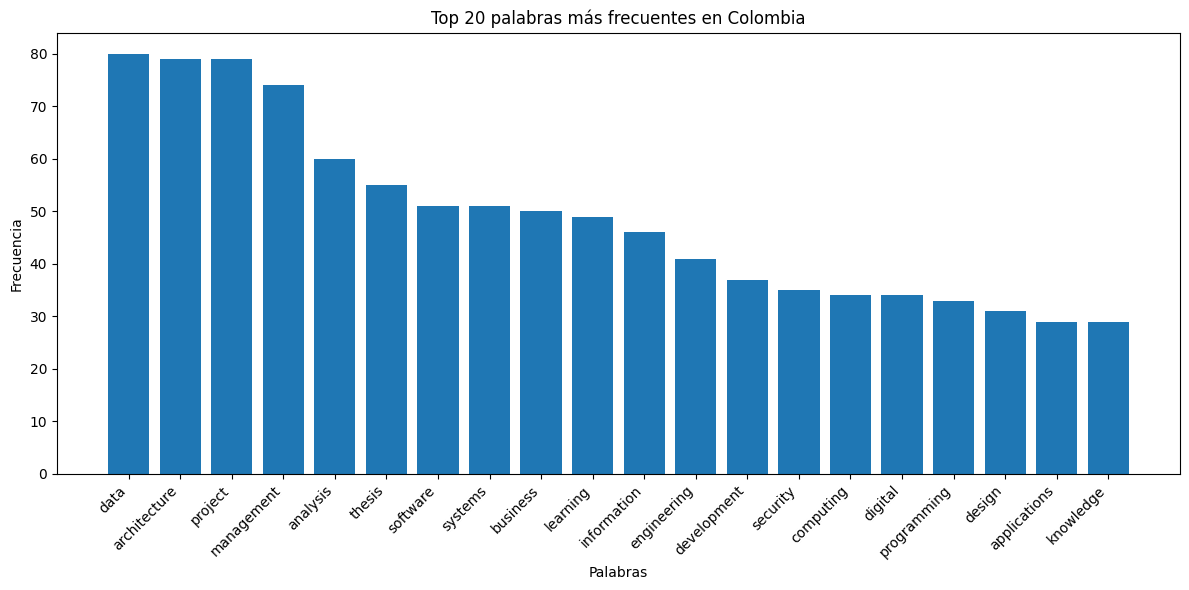


=== Distribución de tópicos por región ===


dominant_topic,0,1,2,3,4,5,6,7,8,9
region,,,,,,,,,,
Colombia,52,122,89,120,166,126,55,120,112,126
World,339,152,161,312,226,154,220,172,171,254


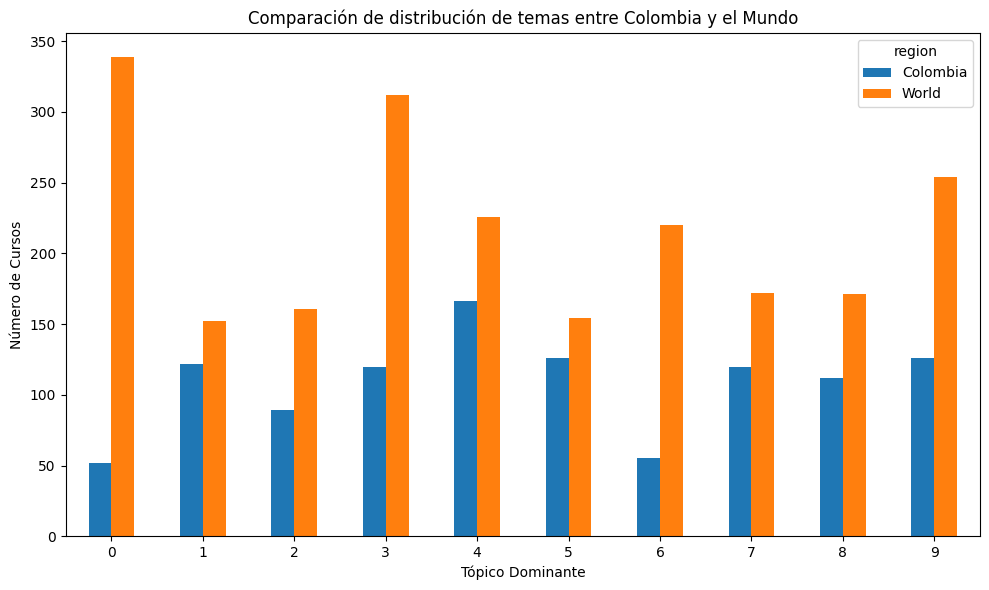

In [66]:
# 2. Cargar y unir datasets
import pandas as pd
# Cargar datasets
df_world = pd.read_csv('/content/courses_clean.csv')
df_colombia = pd.read_csv('/content/courses_clean_colombia.csv')


# Añadir la columna de región
df_world['region'] = 'World'
df_colombia['region'] = 'Colombia'

# Unir los datasets
df_combined = pd.concat([df_world, df_colombia], ignore_index=True)


#df_combined = pd.concat([df_world, df_colombia], ignore_index=True)

# 3. Preprocesamiento
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt', force=True)
nltk.download('stopwords', force=True)

def preprocess_text(text):
    if not isinstance(text, str):
        return ''
    text = text.lower()
    text = re.sub(r'[^a-záéíóúñü\s]', '', text)
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    custom_stopwords = {'en', 'le', 'cs','ii','cse','eng','ee','cis','cr'}
    stop_words.update(custom_stopwords)
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df_combined['processed_text'] = df_combined['name'].apply(preprocess_text)
df_combined['credits'] = df_combined['credits'].fillna(df_combined['credits'].median())

# 4. Modelado: LDA combinado
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

vectorizer = CountVectorizer(max_features=1000)
X = vectorizer.fit_transform(df_combined['processed_text'])

lda = LatentDirichletAllocation(n_components=10, random_state=0)
lda.fit(X)

# 5. Asignar tópicos
df_combined['dominant_topic'] = lda.transform(X).argmax(axis=1)

# 6. Mostrar palabras clave por tema
feature_names = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(lda.components_):
    print(f"\nTema #{topic_idx}:")
    print([feature_names[i] for i in topic.argsort()[:-11:-1]])
    print("-" * 30)

# 7. Visualización: Wordcloud por región
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def plot_wordcloud_region(region):
    subset = df_combined[df_combined['region'] == region]
    all_text = ' '.join(subset['processed_text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Nube de Palabras - {region}")
    plt.tight_layout()
    plt.show()

plot_wordcloud_region('World')
plot_wordcloud_region('Colombia')
# 8. Visualización: Palabras más frecuentes por región
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

def plot_top_words(df, dataset_name, max_features=1000, top_n=20):
    print(f"\n==== Frecuencia de Palabras en {dataset_name} ====")

    vectorizer = CountVectorizer(max_features=max_features)
    X = vectorizer.fit_transform(df['processed_text'])

    feature_names = vectorizer.get_feature_names_out()
    word_freq = np.array(X.sum(axis=0)).flatten()
    word_freq_dict = dict(zip(feature_names, word_freq))

    sorted_items = sorted(word_freq_dict.items(), key=lambda item: item[1], reverse=True)
    top_words = sorted_items[:top_n]

    words, freqs = zip(*top_words)

    plt.figure(figsize=(12, 6))
    plt.bar(words, freqs)
    plt.xticks(rotation=45, ha='right')
    plt.title(f"Top {top_n} palabras más frecuentes en {dataset_name}")
    plt.xlabel("Palabras")
    plt.ylabel("Frecuencia")
    plt.tight_layout()
    plt.show()

# Filtrar datasets por región para reutilizar df_combined
df_world_filtered = df_combined[df_combined['region'] == 'World']
df_colombia_filtered = df_combined[df_combined['region'] == 'Colombia']

# Graficar top palabras
plot_top_words(df_world_filtered, "World")
plot_top_words(df_colombia_filtered, "Colombia")

# 9. Conteo por región y tópico para comparación global
topic_counts = df_combined.groupby(['region', 'dominant_topic']).size().unstack(fill_value=0)
print("\n=== Distribución de tópicos por región ===")
display(topic_counts)

# 10. Gráfico comparativo
topic_counts.T.plot(kind='bar', figsize=(10,6))
plt.title("Comparación de distribución de temas entre Colombia y el Mundo")
plt.xlabel("Tópico Dominante")
plt.ylabel("Número de Cursos")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()



In [ ]:
df_world

,university,program,name,credits,mode,processed_text,dominant_topic
0,Stanford,CS-MS - Computer Science (MS),CS-MS - Computer Science (MS),6.0,NaN,csms computer science ms,3
1,Harvard,Master's in Computational Science and Engineer...,Data Science 1: Introduction to Data Science,6.0,NaN,data science introduction data science,3
2,Harvard,Master's in Computational Science and Engineer...,Data Science 2: Advanced Topics in Data Science,6.0,NaN,data science advanced topics data science,3
3,Harvard,Master's in Computational Science and Engineer...,Advanced Practical Data Science,6.0,NaN,advanced practical data science,3
4,Harvard,Master's in Computational Science and Engineer...,Critical Thinking in Data Science,6.0,NaN,critical thinking data science,2
...,...,...,...,...,...,...,...
2156,Sapienza University of Rome,Maestría en Ciencia de Datos,A elección del estudiante,6.0,NaN,elección del estudiante,1
2157,Sapienza University of Rome,Maestría en Ciencia de Datos,A elección del estudiante,6.0,NaN,elección del estudiante,1
2158,Sapienza University of Rome,Maestría en Ciencia de Datos,Otras habilidades útiles para la inclusión en ...,6.0,NaN,otras habilidades útiles para la inclusión el ...,2
2159,Sapienza University of Rome,Maestría en Ciencia de Datos,Examen final,6.0,NaN,examen final,0


In [ ]:
df_colombia

,university,program,name,credits,mode,processed_text,dominant_topic
0,Universidad de los Andes,Maestría en Arquitecturas de Tecnologías de In...,Project Management for Architects,4.0,NaN,project management architects,3
1,Universidad de los Andes,Maestría en Arquitecturas de Tecnologías de In...,Effective communication for architects,4.0,NaN,effective communication architects,2
2,Universidad de los Andes,Maestría en Arquitecturas de Tecnologías de In...,Business architecture and IT strategy,4.0,NaN,business architecture strategy,0
3,Universidad de los Andes,Maestría en Arquitecturas de Tecnologías de In...,Fundamentals of architecture,4.0,NaN,fundamentals architecture,3
4,Universidad de los Andes,Maestría en Arquitecturas de Tecnologías de In...,Business architecture,4.0,NaN,business architecture,0
...,...,...,...,...,...,...,...
1083,Universidad de Santander,Maestría en Estadística Aplicada y Analítica d...,Elective 3,4.0,NaN,elective,3
1084,Universidad Tecnológica de Bolívar,Maestría en Ciberseguridad,Master in cybersecurity,4.0,Presencial,master cybersecurity,2
1085,Universidad Tecnológica de Bolívar,Maestría en Ciberseguridad,Master in Education mediated by ICT - Virtual,4.0,Virtual,master education mediated ict virtual,1
1086,Universidad Tecnológica de Bolívar,Maestría en Ciberseguridad,Master in Industry 4.0 and Industrial Automation,4.0,Presencial,master industry industrial automation,1


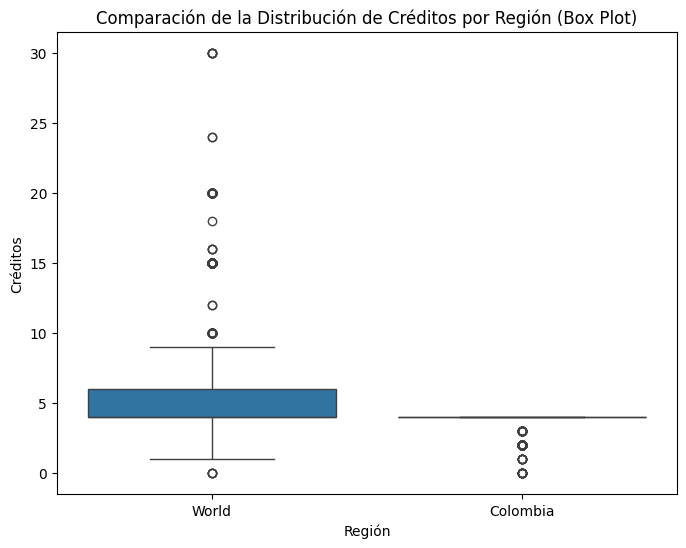

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns

# Asegúrate de que df_combined esté disponible y contenga las columnas 'credits' y 'region'
# Si no, puedes crear df_combined uniendo df_world y df_colombia como se hizo antes:
# df_world['region'] = 'World'
# df_colombia['region'] = 'Colombia'
# df_combined = pd.concat([df_world, df_colombia], ignore_index=True)

plt.figure(figsize=(8, 6))
sns.boxplot(x='region', y='credits', data=df_combined)
plt.title('Comparación de la Distribución de Créditos por Región (Box Plot)')
plt.xlabel('Región')
plt.ylabel('Créditos')
plt.show()